In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:35931 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 6.24 GB


In [3]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/home/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc')
end = time.time()
print(end - start)

13.933279752731323


# Prepare data for processing

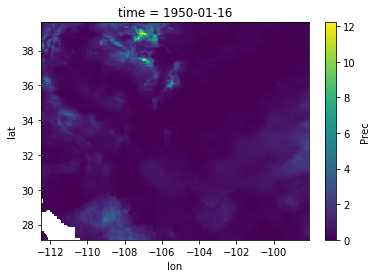

In [28]:
#Create a sub DataArray over smaller area; view some of the data to make sure not all NAN
ds2 = ds.isel(lat=slice(200,400), lon=slice(200,430), time=slice(0,400))
#ds2 = ds.isel(time=slice(0,60))
ds2.Prec.isel(time=0).load()
ds2.Prec.isel(time=0).plot()

In [29]:
#Stack the data along the space time axis
ds3 = ds2.stack(points=['lon','lat'])

In [30]:
#Shape the data
shape = ds3.Prec.data
shape = da.transpose(shape)
shape

dask.array<transpose, shape=(46000, 400), dtype=float32, chunksize=(46000, 1)>

# Compute DWT

In [43]:
#Set the number of levels for DWT, as well as the wavelet
levels = 4
wave = 'haar'

#figure out max possible levels to loop over given size of data
max_level = pywt.dwt_max_level(data_len = shape.shape[1], filter_len = pywt.Wavelet(wave).dec_len) 

In [44]:
#Perform dwt on quantized data.
wp = pywt.wavedec(data=shape, wavelet=wave, level = min(levels,max_level))
#wp = pywt.dwtn(data=data_quant, wavelet=wave)

In [45]:
wp[0].shape

(46000, 25)

In [46]:
wp[0][0]

array([0.517878  , 1.4533608 , 1.4716711 , 0.67764604, 0.4470726 ,
       0.9430381 , 1.3111608 , 2.0962613 , 0.5024995 , 0.9430275 ,
       0.33240902, 0.29896882, 0.3743546 , 1.5052158 , 0.62869275,
       0.17433408, 0.32286823, 1.3639659 , 0.91967237, 0.75415736,
       1.3799865 , 1.5610526 , 0.43802494, 1.2240202 , 1.4632378 ],
      dtype=float32)

In [47]:
#View the distribution of the DWT values
np.histogram(wp[0], bins=100, range =[np.nanmin(wp[0]), np.nanmax(wp[0])])

/home/ddesantis/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ddesantis/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  100,   518,  1966,  7583, 16703, 27123, 40033, 53616, 62812,
        69993, 72396, 70702, 69469, 65810, 62793, 56888, 52410, 48791,
        43866, 39370, 35056, 31861, 29232, 25980, 23340, 18913, 16432,
        14710, 13142, 10992,  9396,  7620,  6304,  5333,  4409,  3739,
         2839,  2261,  2010,  1511,  1164,   996,   836,   681,   505,
          448,   341,   314,   278,   206,   200,   163,   133,   128,
          109,    98,    72,    80,    60,    57,    48,    43,    39,
           29,    40,    36,    32,    14,    20,    15,    13,    14,
           16,    12,    11,     6,     7,     6,    10,     7,     5,
            7,     3,     6,     4,     9,     6,     2,     4,     3,
            3,     2,     1,     3,     2,     1,     2,     1,     0,
            2]),
 array([ 0.08860983,  0.37540729,  0.66220476,  0.94900222,  1.23579969,
         1.52259715,  1.80939462,  2.09619208,  2.38298955,  2.66978701,
         2.95658448,  3.24338194,  3.53017941,  3.816976

In [48]:
np.count_nonzero(~np.isnan(wp[0]))

1135375

# Threshold the results of DWT

In [135]:
#Pick a threshold value.  
# For climate data, we probably only want the approximate (low frequency) coefficents to cluster. 
epsilon = .0001

In [136]:
#Threshold the DWT
wp[0][abs(wp[0])<epsilon] = 0
wp[0][abs(wp[0])>=epsilon] = 1

In [137]:
#View the distribution of the threshold DWT values
np.histogram(wp[0], bins=100)

(array([39311,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         7345]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29

# Find connected components

In [138]:
#Compute the connected components of each thresholed DWT.  Adjacnecy is determined by ``four'' connectivity.
component = ndimage.label(wp[0])[0]

In [140]:
np.histogram(component, bins=3)

(array([39311,  7339,     6]), array([0., 1., 2., 3.]))

In [ ]:
#Remove components that have a small number of points in them?

In [139]:
#Check number of connected components
np.max(component)

3